# Test 6
Fuck me i hate my life

## General Shit

In [2]:
import numpy as np
import os.path as path
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, ConfusionMatrixDisplay
import pandas as pd
import monke_features as mf
import monke_classify as mc
import monke_io as mio
import matplotlib.pyplot as plt

In [3]:
# KOI
names_koi = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_5", "koi_apr25_6"]

pose_data_koi = mio.read_poses(names_koi)
tremors_raw = mio.read_tremors_multi(names_koi)
labels_koi = {}

for name in tremors_raw:
    labels_koi[name] = mf.generate_labelled_frames(pose_data_koi[name], tremors_raw[name])

# BOBA
names_boba = ["boba_apr11", "boba_apr21", "boba_apr21_2", "boba_apr25", "boba_apr25_2"]

pose_data_boba = mio.read_poses(names_boba)
tremors_raw = mio.read_tremors_multi(names_boba)
labels_boba = {}

for name in tremors_raw:
    labels_boba[name] = mf.generate_labelled_frames(pose_data_boba[name], tremors_raw[name])

# ALL
names_all = [*names_koi, *names_boba]
pose_data_all = mio.read_poses(names_all)

tremors_raw = mio.read_tremors_multi(names_all)
labels_all = {}

for name in tremors_raw:
    labels_all[name] = mf.generate_labelled_frames(pose_data_all[name], tremors_raw[name])

In [4]:
def prep_train_test_data(pose_data, labels, train_names, weights=None, test_size=0.2):
    training_data = []
    training_labels = []

    if weights is not None:
        training_weights = []

    testing_data = pose_data.copy()
    testing_labels = labels.copy()

    for name in train_names:
        pose_train = pose_data[name]
        labels_train = labels[name]

        if weights is not None:
            weights_train = weights[name]
            X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(pose_train, labels_train, weights_train, test_size=test_size)
            training_weights.append(z_train)
        else:
            X_train, X_test, y_train, y_test = train_test_split(pose_train, labels_train, test_size=test_size)
        training_data.append(X_train)
        training_labels.append(y_train)
        testing_data[name] = X_test
        testing_labels[name] = y_test

    if weights is None:
        return np.concatenate(training_data), testing_data, np.concatenate(training_labels), testing_labels
    else:
        return np.concatenate(training_data), testing_data, np.concatenate(training_labels), testing_labels, np.concatenate(training_weights)

def prep_multi_train_test_data(pose_data, labels, train_names, weights=None, test_size=0.2):
    training_data = {}
    training_labels = {}

    testing_data = {}
    testing_labels = {}

    for name in train_names:
        pose_train = pose_data[name]
        labels_train = labels[name]
        X_train, X_test, y_train, y_test = train_test_split(pose_train, labels_train, test_size=test_size)

        training_data[name] = X_train
        training_labels[name] = y_train
        testing_data[name] = X_test
        testing_labels[name] = y_test

    return training_data, testing_data, training_labels, testing_labels


def process_data(pose_data, labels, process):
    processed_data = {}
    processed_labels = {}

    for name in pose_data:
        processed_data[name] = process(pose_data[name])
        processed_labels[name] = labels[name][:processed_data[name].shape[0]]
    
    return processed_data, processed_labels

def test_classify(clf, test_data, test_labels):
    predicted_labels = clf.predict(test_data)
    mcc = matthews_corrcoef(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)
    return {"predictions":predicted_labels, "mcc":mcc, "f1":f1}

## Test 6A: Video to Video

**Aim**: Check how classifiers predict a video's tremors when trained on another video or the same video.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

_Training Data (Individually)_
* Koi, April 11 (80%)
* Koi, April 17 (80%)
* Koi, April 25 (80%)
* Koi, April 25 (3) (80%)
* Koi, April 25 (4) (80%)
* Koi, April 25 (5) (80%)
* Koi, April 25 (6) (80%)
* Boba, April 11 (80%)
* Boba, April 21 (80%)
* Boba, April 21 (2) (80%)
* Boba, April 25 (80%)
* Boba, April 25 (2) (80%)

_Testing Data_
* Koi, April 11 (20%)
* Koi, April 17 (20%)
* Koi, April 25 (20%)
* Koi, April 25 (3) (20%)
* Koi, April 25 (4) (20%)
* Koi, April 25 (5) (20%)
* Koi, April 25 (6) (20%)
* Boba, April 11 (20%)
* Boba, April 21 (20%)
* Boba, April 21 (2) (20%)
* Boba, April 25 (20%)
* Boba, April 25 (2) (20%)

In [5]:
process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)

processed_data, processed_labels = process_data(pose_data_all, labels_all, process)
training_data, testing_data, training_labels, testing_labels = prep_multi_train_test_data(processed_data, processed_labels, names_all)

results_6a = {}

for name in training_data:
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(training_data[name], training_labels[name])

    results_6a[name] = {}

    for testing_name in testing_data:
        results_6a[name][testing_name] = test_classify(clf, testing_data[testing_name], testing_labels[testing_name])

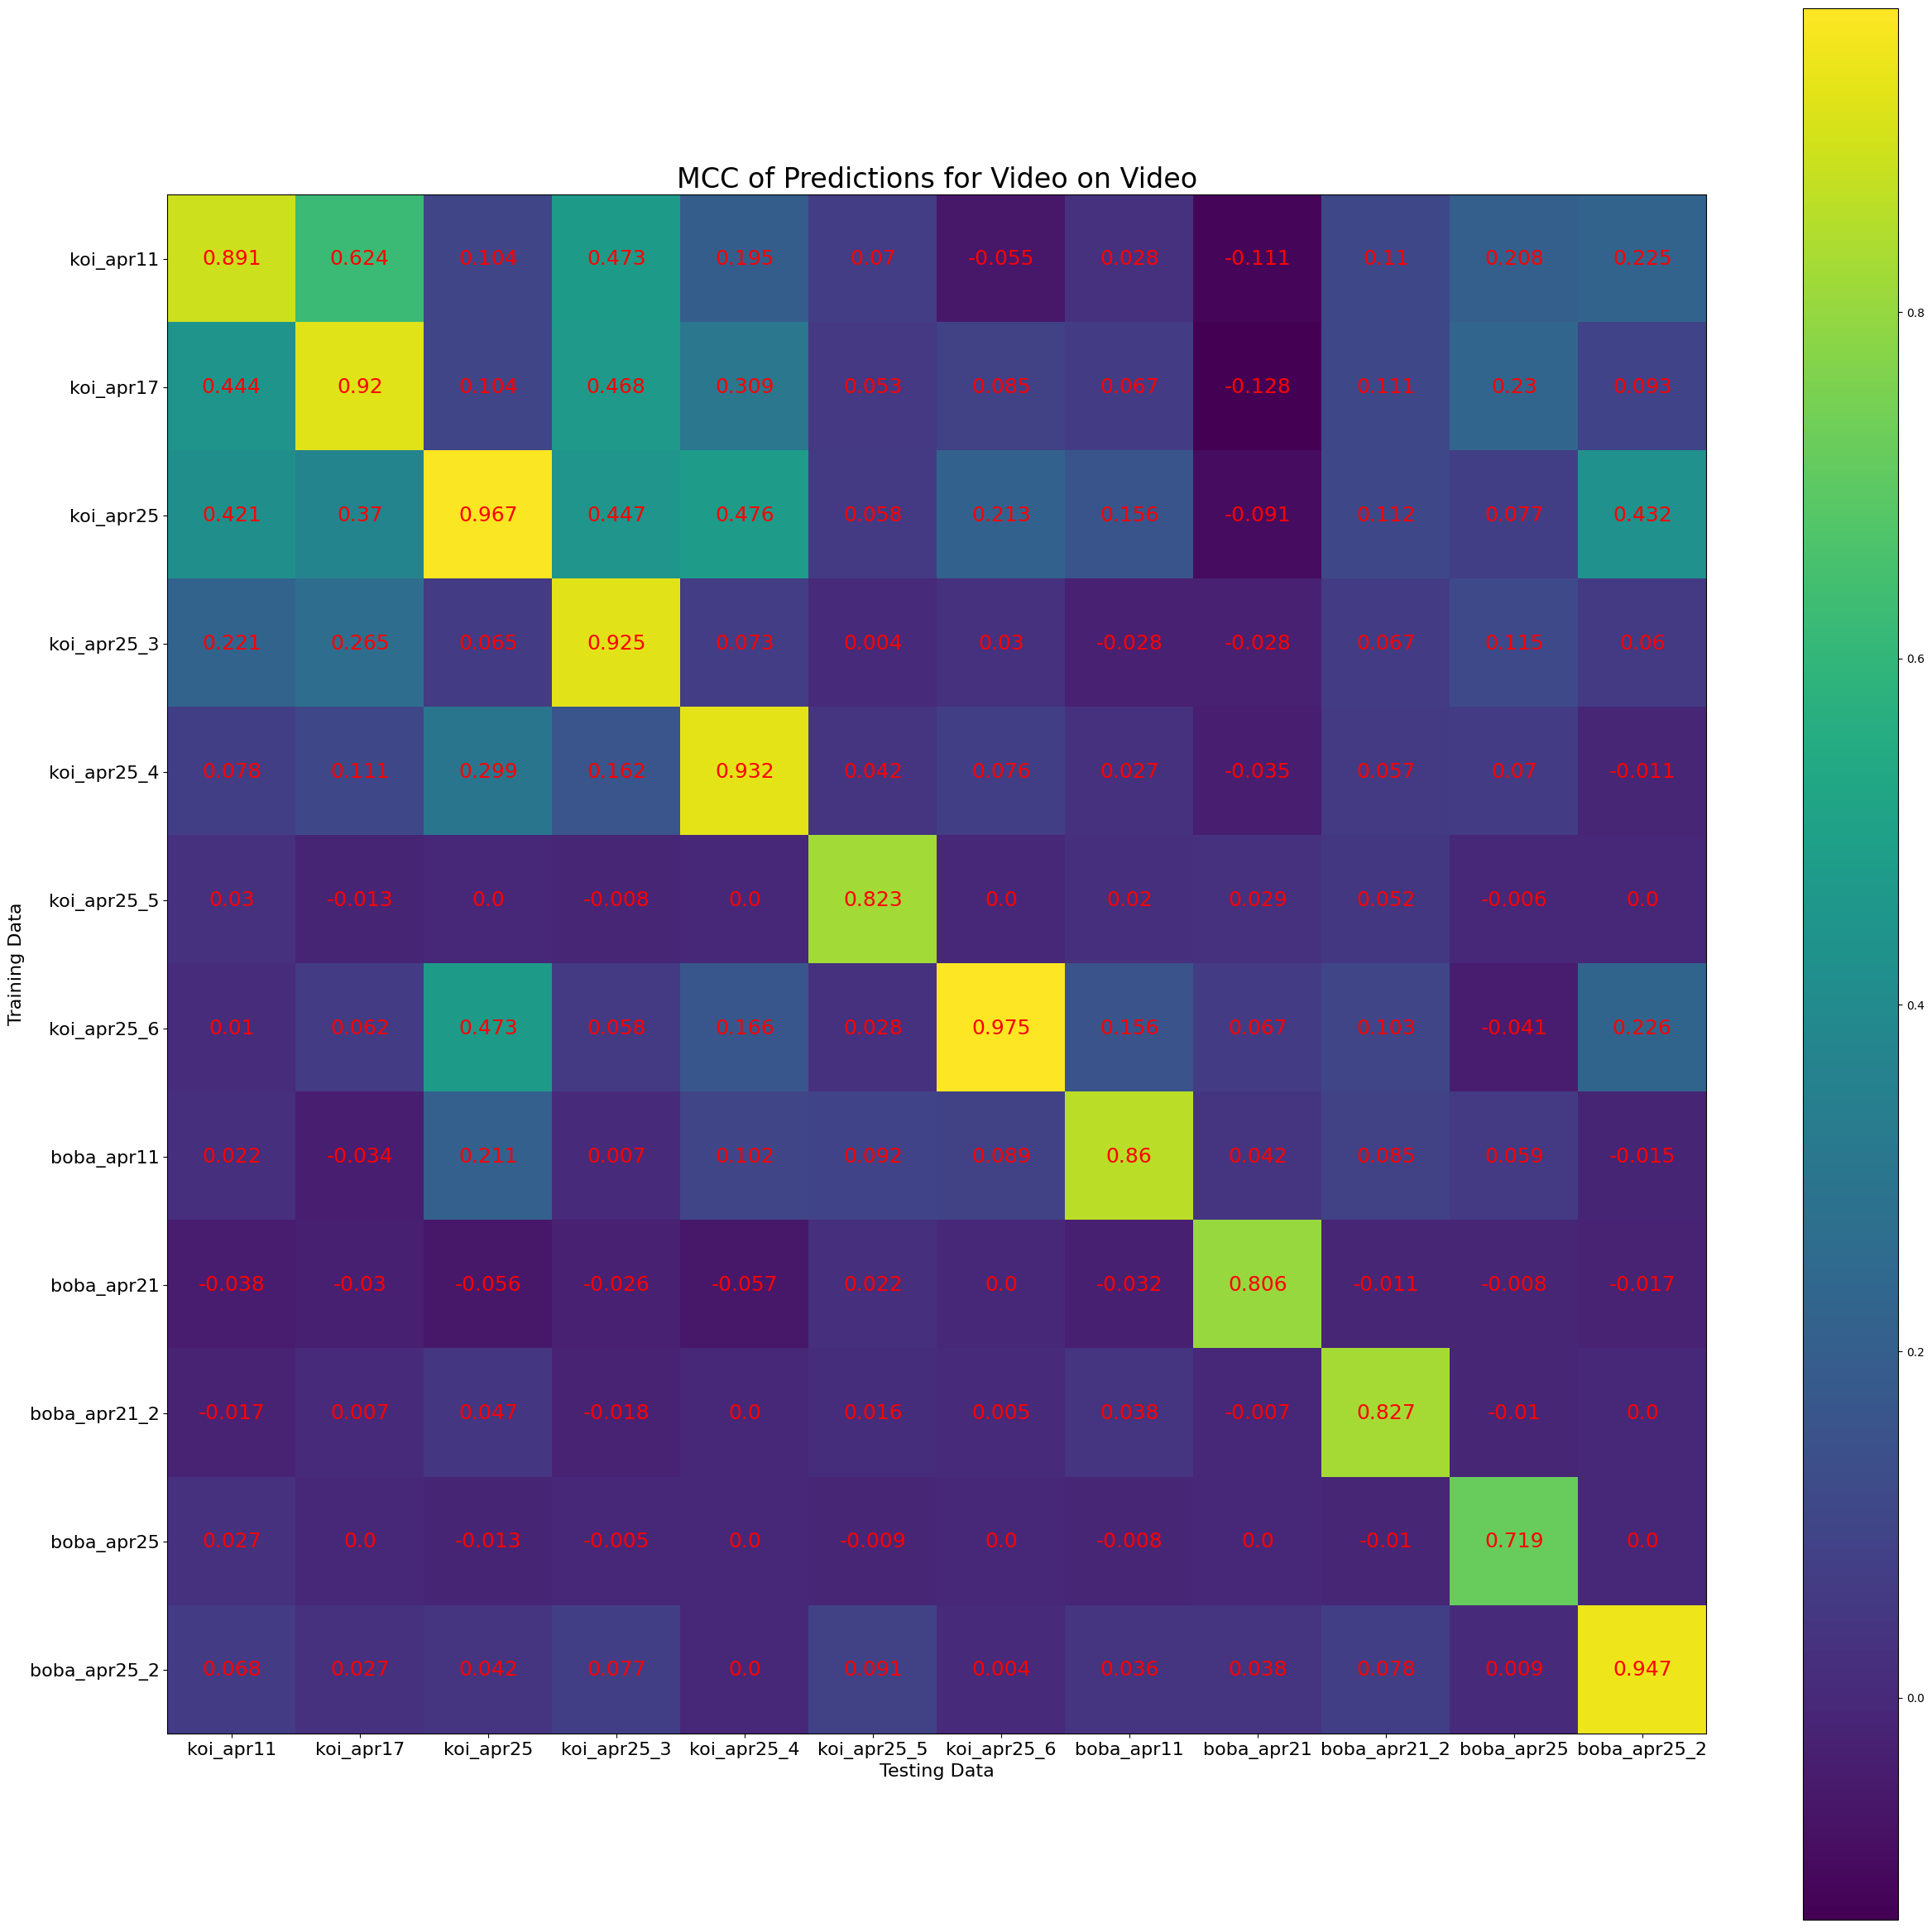

In [6]:
visualise_6a = []

for train_name in results_6a:
    train_row = []
    for test_name in results_6a[train_name]:
        train_row.append(results_6a[train_name][test_name]["mcc"])
    visualise_6a.append(train_row)

plt.imshow(visualise_6a)

plt.title("MCC of Predictions for Video on Video", size=24)
plt.xlabel("Testing Data", size=16)
plt.ylabel("Training Data", size=16)
plt.xticks(range(len(names_all)), names_all, size=16)
plt.yticks(range(len(names_all)), names_all, size=16)

for r in range(len(visualise_6a)):
    for c in range(len(visualise_6a[r])):
        plt.text(c, r, round(visualise_6a[r][c], 3), ha='center', va='center', color="red", size=18)

plt.colorbar()
plt.gcf().set_size_inches(30, 30)
plt.show()

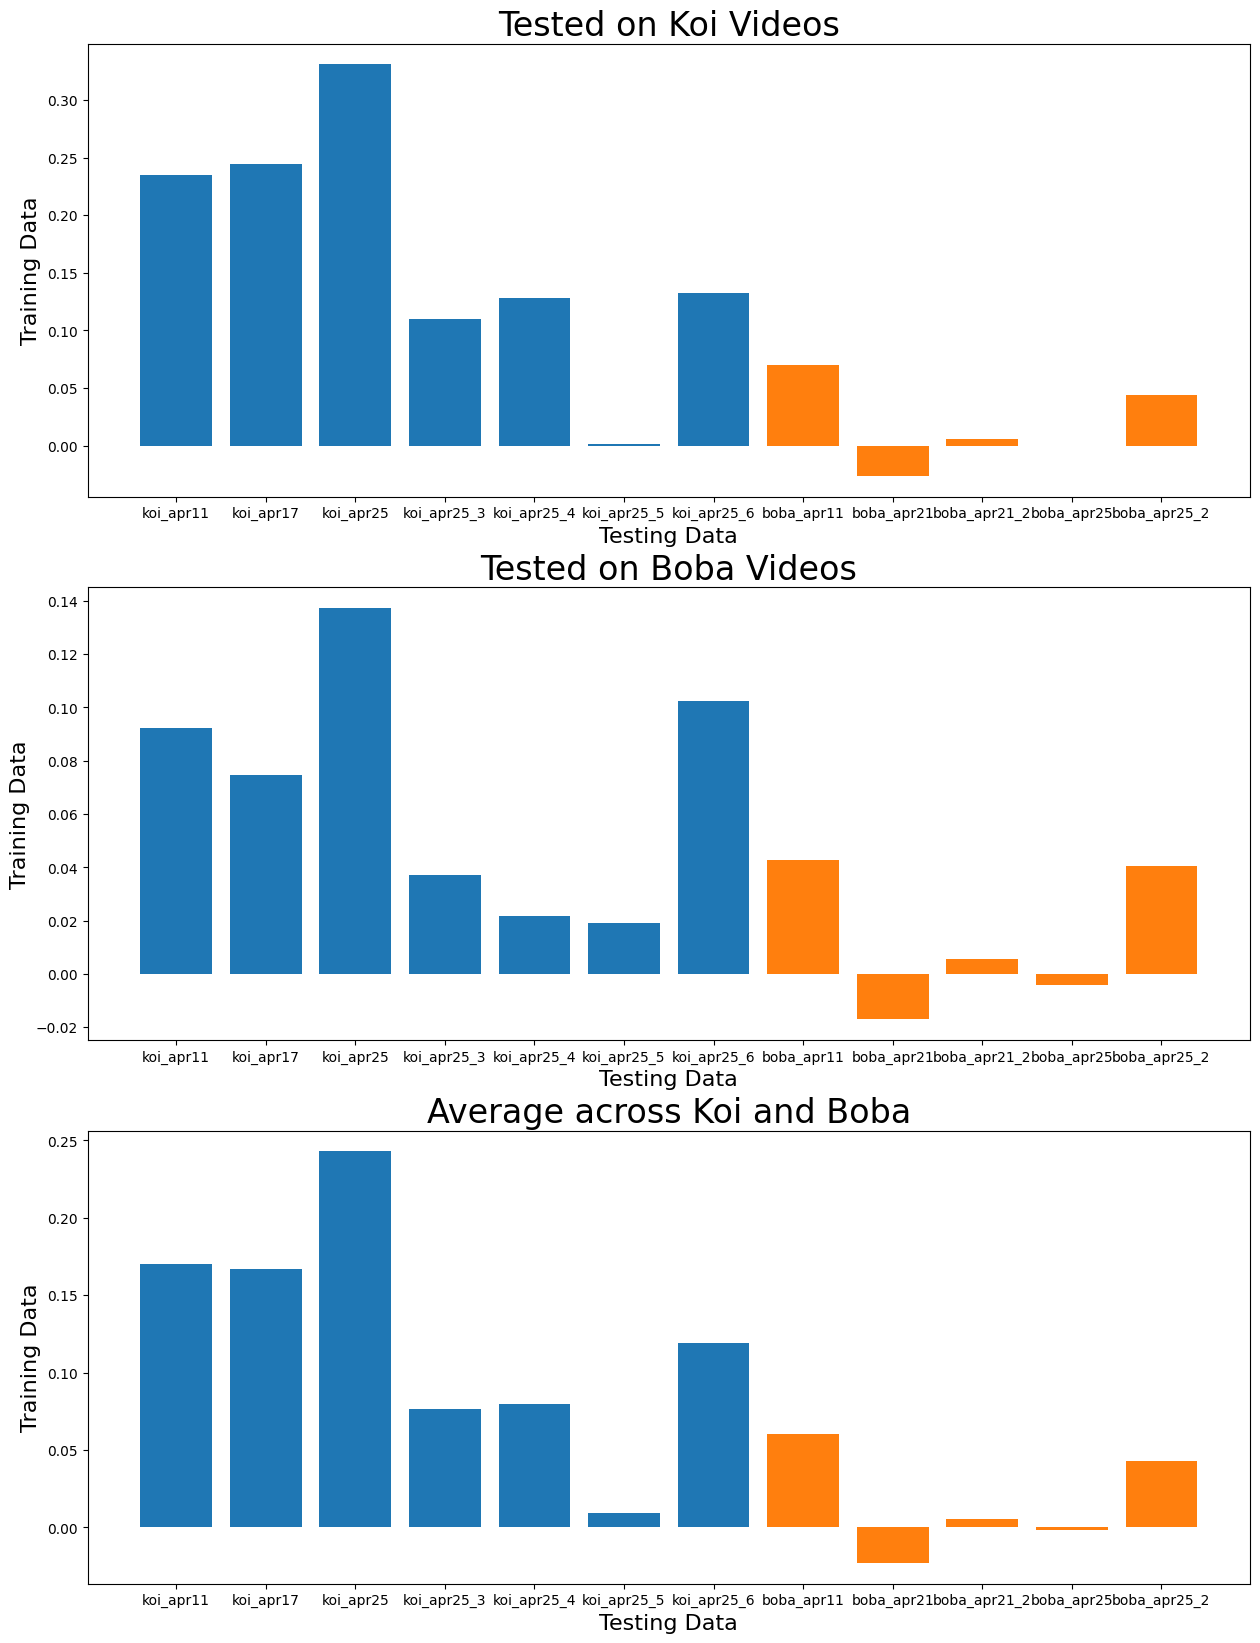

In [16]:
bar_koi_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name) and ("koi" in test_name)]) for train_name in results_6a]
bar_boba_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name) and ("boba" in test_name)]) for train_name in results_6a]
bar_mean_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name)]) for train_name in results_6a]

fig, ax = plt.subplots(nrows=3, ncols=1)

plt.title("Average MCC of Predictions when Trained on Single Video Data")

ax[0].bar(names_all, bar_koi_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[0].set_title("Tested on Koi Videos",size=24)
ax[0].set_xlabel("Testing Data", size=16)
ax[0].set_ylabel("Training Data", size=16)

ax[1].bar(names_all, bar_boba_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[1].set_title("Tested on Boba Videos",size=24)
ax[1].set_xlabel("Testing Data", size=16)
ax[1].set_ylabel("Training Data", size=16)

ax[2].bar(names_all, bar_mean_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[2].set_title("Average across Koi and Boba",size=24)
ax[2].set_xlabel("Testing Data", size=16)
ax[2].set_ylabel("Training Data", size=16)

plt.gcf().set_size_inches(15, 20)
plt.show()

## Test 6B: How Many Videos?

**Aim**: Check how the number of videos used in training affects predictions.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

_Training Data (Individually)_
* Koi, April 11 (80%)
* Koi, April 17 (80%)
* Koi, April 25 (80%)
* Koi, April 25 (3) (80%)
* Koi, April 25 (4) (80%)
* Koi, April 25 (5) (80%)
* Koi, April 25 (6) (80%)
* Boba, April 11 (80%)
* Boba, April 21 (80%)
* Boba, April 21 (2) (80%)
* Boba, April 25 (80%)
* Boba, April 25 (2) (80%)

_Testing Data_
* Koi, April 11 (20%)
* Koi, April 17 (20%)
* Koi, April 25 (20%)
* Koi, April 25 (3) (20%)
* Koi, April 25 (4) (20%)
* Koi, April 25 (5) (20%)
* Koi, April 25 (6) (20%)
* Boba, April 11 (20%)
* Boba, April 21 (20%)
* Boba, April 21 (2) (20%)
* Boba, April 25 (20%)
* Boba, April 25 (2) (20%)

In [8]:
process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)

processed_data, processed_labels = process_data(pose_data_all, labels_all, process)
training_data, testing_data, training_labels, testing_labels = prep_multi_train_test_data(processed_data, processed_labels, names_all)

for name in training_data:
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(training_data[name], training_labels[name])

    results_6a[name] = {}

    for testing_name in testing_data:
        results_6a[name][testing_name] = test_classify(clf, testing_data[testing_name], testing_labels[testing_name])

KeyboardInterrupt: 